# Estudo sobre Previsão de Vendas Utilizando Modelos Tradicionais (ARIMA), Machine Learning e Redes Neurais Profundas  

### Autor: André Rizzo  

<br>

### Descrição do Projeto  

One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.  

<br>

#### Dataset:
You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.  

A base fornecida é coposta dos arquivos abaixo:  

**stores.csv:**  
This file contains anonymized information about the 45 stores, indicating the type and size of store.

**train.csv**  
This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:  
Store - the store number  
Dept - the department number  
Date - the week  
Weekly_Sales -  sales for the given department in the given store  
IsHoliday - whether the week is a special holiday week  

**test.csv**  
This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

**features.csv**  
This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:  
- Store - the store number  
- Date - the week  
- Temperature - average temperature in the region  
- Fuel_Price - cost of fuel in the region  
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.  
- CPI - the consumer price index  
- Unemployment - the unemployment rate  
- IsHoliday - whether the week is a special holiday week  

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13  

### Carregar as bibliotecas necessárias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import kagglehub

from google.colab import drive

<br>

### Obter o dataset

In [3]:
# Mapeia Google Drive
drive.mount('/content/drive')

# Cria diretório no Google Colab para armazenar a Kaggle Key
! mkdir ~/.kaggle

# Copia Kaggle Key do Google Drive para o Colab
!cp /content/drive/MyDrive/Projetos/Kaggle/kaggle.json ~/.kaggle/kaggle.json

# Faz o download da base de dados diretamente do Kaggle
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
print('Download finalizado')

# Descompacta o arquivo zip com o dataset
! unzip walmart-recruiting-store-sales-forecasting.zip > unzip_log.txt 2>&1
! rm -rf walmart-recruiting-store-sales-forecasting.zip
print('walmart-recruiting-store-sales-forecasting.zip descompactado')

# Descompacta os arquivos individuais
! unzip features.csv.zip > unzip_log.txt 2>&1
! rm -rf features.csv.zip
print('Arquivo features.zip descompactado')

! unzip train.csv.zip > unzip_log.txt 2>&1
! rm -rf train.csv.zip
print('Arquivo train.zip descompactado')

! unzip test.csv.zip > unzip_log.txt 2>&1
! rm -rf test.csv.zip
print('Arquivo test.zip descompactado')

! unzip sampleSubmission.csv.zip > unzip_log.txt 2>&1
! rm -rf sampleSubmission.csv.zip
print('Arquivo sampleSubmission.zip descompactado')



Mounted at /content/drive
 74% 2.00M/2.70M [00:00<00:00, 2.51MB/s]
100% 2.70M/2.70M [00:01<00:00, 2.80MB/s]
Download finalizado
walmart-recruiting-store-sales-forecasting.zip descompactado
Arquivo features.zip descompactado
Arquivo train.zip descompactado
Arquivo test.zip descompactado
Arquivo sampleSubmission.zip descompactado


<br>

### Carregar cada um dos arquivos

In [4]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

<br>

### Exploração Inicial dos arquivos

#### Features

In [4]:
features.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False


In [5]:
features.shape

(8190, 12)

O dataframe *features* possui 12 variáveis e 8190 observações.

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [ ]:
valores_ausentes_features = features.isnull().sum()
print(valores_ausentes_features)

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [ ]:
# Calcular o % de valores ausentes
percent_missing = features.isnull().sum() * 100 / len(features)
missing_value_df = pd.DataFrame({'column_name': features.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

               column_name  percent_missing
Store                Store         0.000000
Date                  Date         0.000000
Temperature    Temperature         0.000000
Fuel_Price      Fuel_Price         0.000000
MarkDown1        MarkDown1        50.769231
MarkDown2        MarkDown2        64.334554
MarkDown3        MarkDown3        55.885226
MarkDown4        MarkDown4        57.704518
MarkDown5        MarkDown5        50.549451
CPI                    CPI         7.142857
Unemployment  Unemployment         7.142857
IsHoliday        IsHoliday         0.000000


- Avaliar a remoção das variáveis MarkDown 1-5.  
- Realizar imputação das variáveis CPI e Unemployment.   

---  

#### Stores

In [ ]:
stores.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [ ]:
stores.shape

(45, 3)

O dataframe *stores* possui 3 variáveis e 45 observações.  

In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [ ]:
valores_ausentes_stores = stores.isnull().sum()
print(valores_ausentes_stores)

Store    0
Type     0
Size     0
dtype: int64


---

#### Test

In [ ]:
test.head(10)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
5,1,1,2012-12-07,False
6,1,1,2012-12-14,False
7,1,1,2012-12-21,False
8,1,1,2012-12-28,True
9,1,1,2013-01-04,False


In [ ]:
test.shape

(115064, 4)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [ ]:
valores_ausentes_test = test.isnull().sum()
print(valores_ausentes_test)

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64


---  
#### Train  

In [ ]:
train.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [ ]:
train.tail(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
421560,45,98,2012-08-24,415.40,False
421561,45,98,2012-08-31,346.04,False
421562,45,98,2012-09-07,352.44,True
421563,45,98,2012-09-14,605.96,False
421564,45,98,2012-09-21,467.30,False
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [ ]:
train.shape

(421570, 5)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
valores_ausentes_train = train.isnull().sum()
print(valores_ausentes_train)

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


---  

#### Consolidando em um único dataset  

In [5]:
df_full = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df_full = pd.merge(df_full, stores, on=['Store'], how='left')

In [8]:
# Salvar o dataset df_full em um arquivo csv

df_full.to_csv('df_full.csv', index=False)

In [9]:
df_full.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
5,1,1,2010-03-12,21043.39,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6,1,1,2010-03-19,22136.64,False,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,A,151315
7,1,1,2010-03-26,26229.21,False,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,A,151315
8,1,1,2010-04-02,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,A,151315
9,1,1,2010-04-09,42960.91,False,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,A,151315


In [ ]:
df_full.tail(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421560,45,98,2012-08-24,415.40,False,72.62,3.834,7936.20,58.38,22.00,5518.07,2291.97,191.344887,8.684,B,118221
421561,45,98,2012-08-31,346.04,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221
421562,45,98,2012-09-07,352.44,True,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,191.577676,8.684,B,118221
421563,45,98,2012-09-14,605.96,False,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,191.699850,8.684,B,118221
421564,45,98,2012-09-21,467.30,False,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,191.856704,8.684,B,118221
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221
421569,45,98,2012-10-26,1076.80,False,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221


#### Verificando as dimensões do dataset resultante

In [10]:
df_full.shape

(421570, 16)

O dataset resultante possui 421570 observações em 16 variáveis.

In [11]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


#### Verificando os valores ausente

In [ ]:
valores_ausentes = df_full.isnull().sum()
print(valores_ausentes)

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64


In [ ]:
valores_ausentes_perc = df_full.isnull().sum()/len(df_full)*100
print(valores_ausentes_perc)

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64


As variáveis *Markdown 1-5* possuem mais de 60% de valores faltantes, desta forma optei por remove-las do dataset.

#### Removendo as variáveis *Markdown 1-5*

In [6]:
df_full = df_full.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)

In [13]:
df_full.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315
5,1,1,2010-03-12,21043.39,False,57.79,2.667,211.380643,8.106,A,151315
6,1,1,2010-03-19,22136.64,False,54.58,2.720,211.215635,8.106,A,151315
7,1,1,2010-03-26,26229.21,False,51.45,2.732,211.018042,8.106,A,151315
8,1,1,2010-04-02,57258.43,False,62.27,2.719,210.820450,7.808,A,151315
9,1,1,2010-04-09,42960.91,False,65.86,2.770,210.622857,7.808,A,151315


---

<br>

### Análise Exploratória de Dados

#### Visualização da Série Temporal

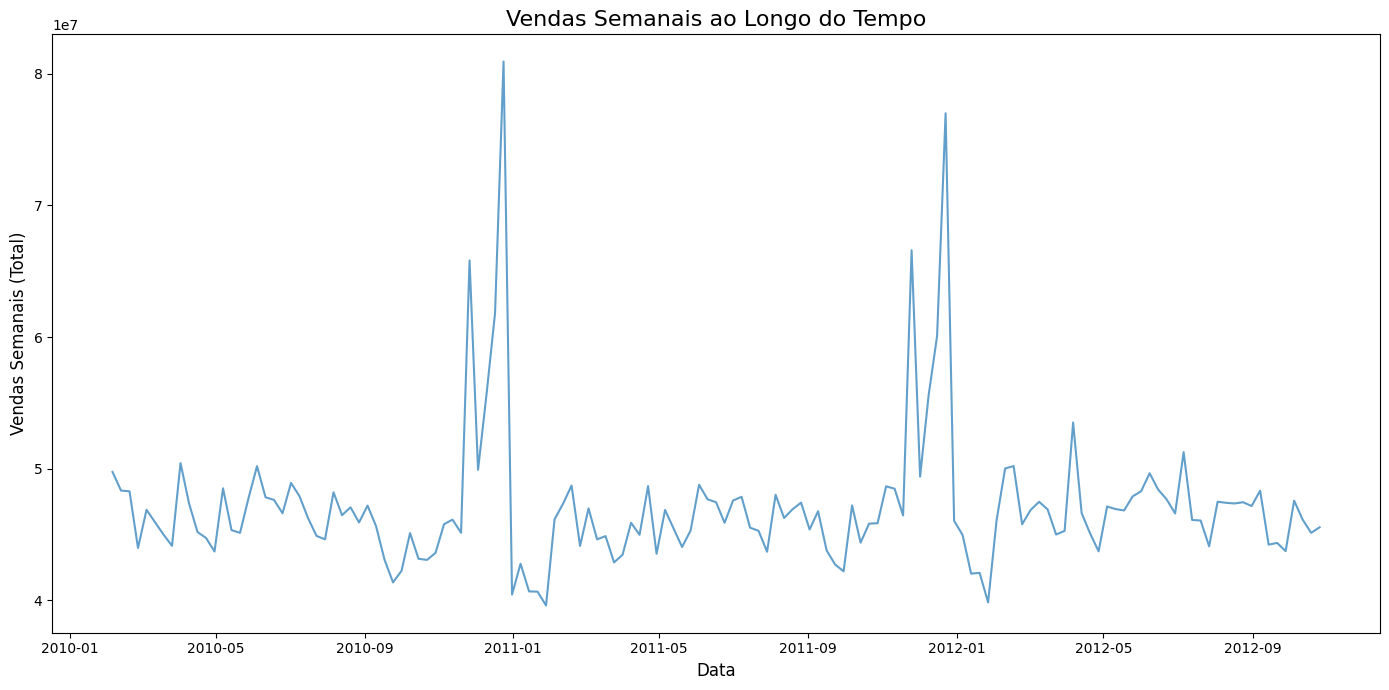

In [7]:
# Convert 'Date' column to datetime for better plotting
train['Date'] = pd.to_datetime(train['Date'])

# Sort by date to ensure proper chronological order
dataset = train.sort_values('Date')

# Group by date to aggregate sales (if necessary)
sales_by_date = dataset.groupby('Date')['Weekly_Sales'].sum()

# Plotting the sales over time
plt.figure(figsize=(14, 7))
plt.plot(sales_by_date.index, sales_by_date.values, linestyle='-', alpha=0.7)
plt.title('Vendas Semanais ao Longo do Tempo', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Vendas Semanais (Total)', fontsize=12)
plt.tight_layout()
plt.show()

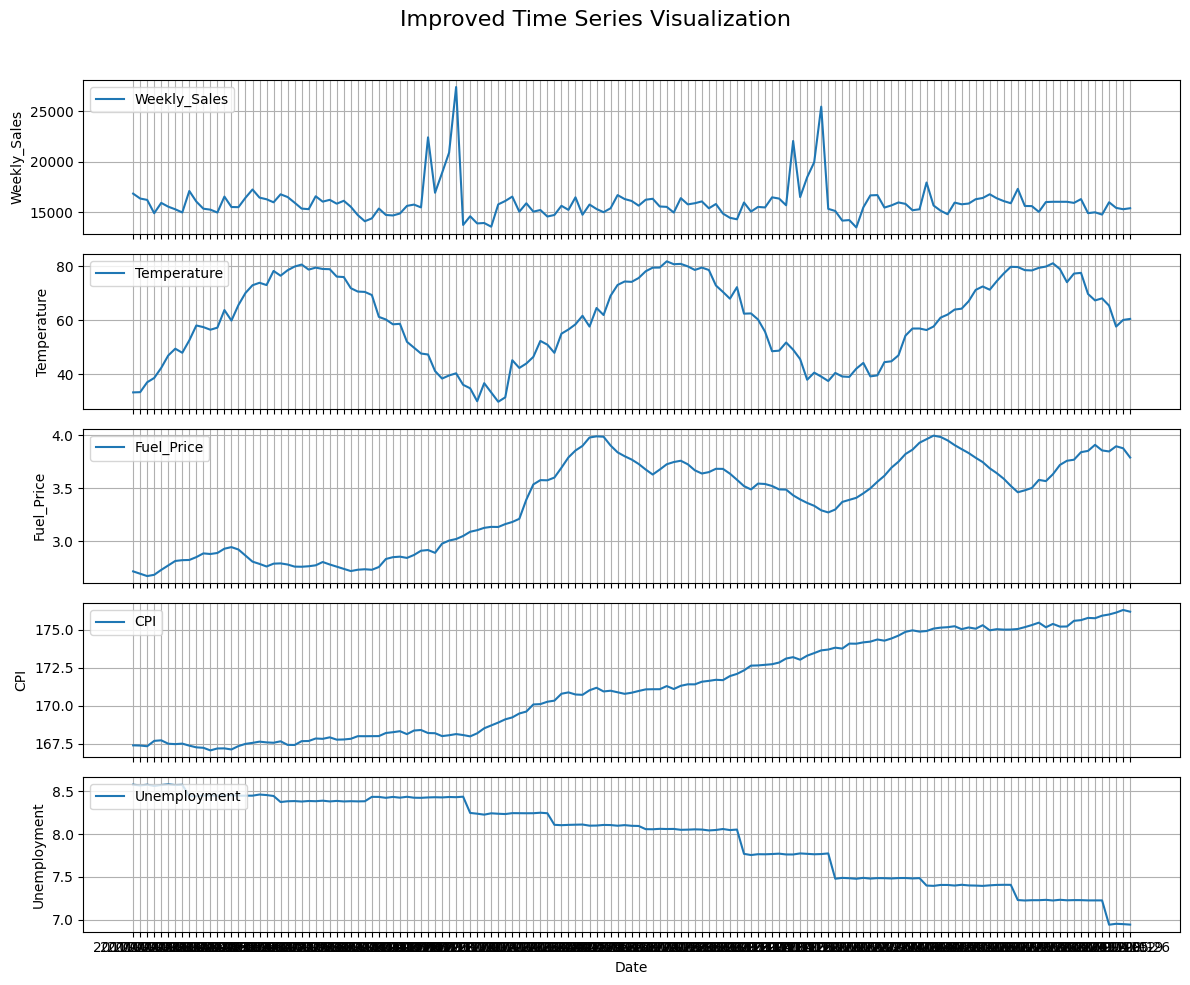

In [16]:
# Aggregate the dataset by Date, excluding non-numeric columns
aggregated_data = df_full.groupby('Date').agg({
    'Weekly_Sales': 'mean',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
})

# The rest of your code remains the same...
# Select variables to plot
variables_to_plot = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
titles = ['Weekly Sales', 'Temperature', 'Fuel Price', 'CPI', 'Unemployment']

# Create subplots
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 10), sharex=True)
fig.suptitle('Improved Time Series Visualization', fontsize=16)

# Plot each variable
for i, var in enumerate(variables_to_plot):
    axes[i].plot(aggregated_data.index, aggregated_data[var], label=var, linewidth=1.5)
    axes[i].set_ylabel(var)
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

# Set common x-axis label
axes[-1].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

#### Visualização da ST decomposta segundo tendência, sazonalidade e ruído.

<Figure size 1400x1000 with 0 Axes>

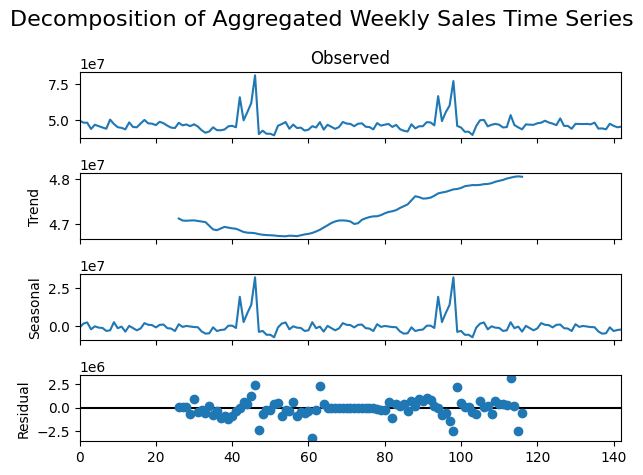

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the aggregated sales time series using additive model
decomposition = seasonal_decompose(sales_by_date.values, model='additive', period=52)

# Plot the decomposition
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Decomposition of Aggregated Weekly Sales Time Series', fontsize=16)
plt.tight_layout()
plt.show()

#### Análise da Estacionaridade

In [11]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(sales_by_date.values, autolag='AIC')

# Extract and display test results
adf_output = {
    "Estatística de teste": adf_result[0],
    "Valores críticos": adf_result[4],
    "\n p-valor": adf_result[1]
}

# Print the results
for key, value in adf_output.items():
    if key == "Valores críticos":
        print(f"{key}:")
        for level, critical_value in value.items():
            print(f"  {level}: {critical_value}")
    else:
        print(f"{key}: {value}")

Estatística de teste: -5.908297957186336
Valores críticos:
  1%: -3.47864788917503
  5%: -2.882721765644168
  10%: -2.578065326612056

 p-valor: 2.675979158986003e-07


**Interpretação:**  

- A estatística do teste (-5.9083) é menor que todos os valores críticos em níveis de 1%, 5% e 10%.  
- O p-valor é significativamente menor que 0.05.  

**Conclusão:**  
A série temporal **é estacionária**, pois rejeitamos a hipótese nula do teste ADF (que assume que a série possui uma raiz unitária).

#### Análise de Autocorrelação e Autocorrelação Parcial

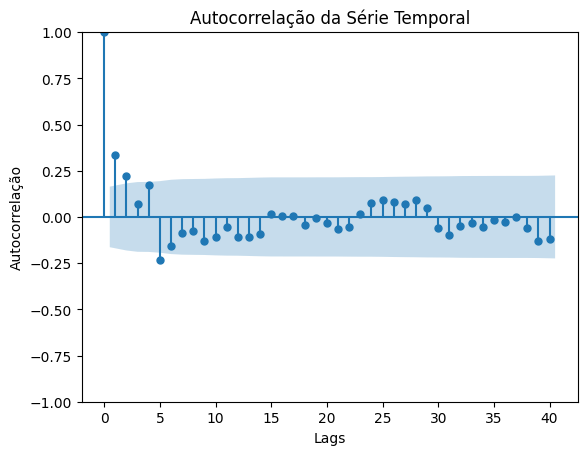

In [17]:
plot_acf(aggregated_data, lags=40)
plt.title('Autocorrelação da Série Temporal')
plt.xlabel('Lags')
plt.ylabel('Autocorrelação')
plt.show()

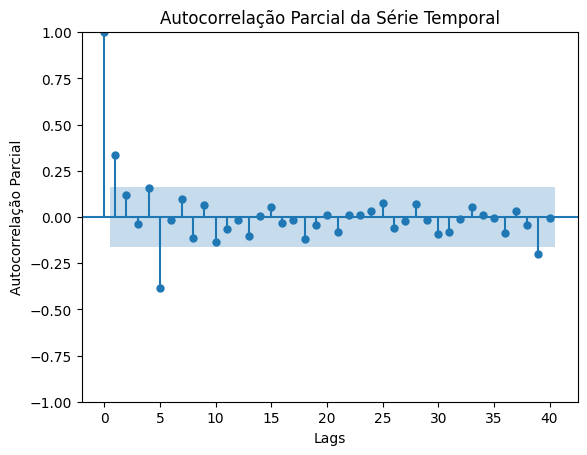

In [18]:
plot_pacf(aggregated_data, lags=40)
plt.title('Autocorrelação Parcial da Série Temporal')
plt.xlabel('Lags')
plt.ylabel('Autocorrelação Parcial')
plt.show()

Observamos uma série sem tendência, porém com sazonalidade.

<br>

---

### Modelagem

#### Modelo VAR

In [19]:
import pandas as pd
from statsmodels.tsa.api import VAR

data_for_var = pd.concat([df_full['Weekly_Sales'], df_full['Temperature'],
                          df_full['Fuel_Price'], df_full['CPI'],
                          df_full['Unemployment']], axis=1)

# Fitting a VAR model
model = VAR(data_for_var)

# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        32.68       32.68   1.560e+14       32.68
1        12.61       12.61   2.998e+05       12.61
2        12.42       12.42   2.481e+05       12.42
3        12.35       12.36   2.318e+05       12.35
4        12.28       12.28   2.146e+05       12.28
5        12.16       12.16   1.907e+05       12.16
6        12.12       12.13   1.837e+05       12.12
7        12.09       12.10   1.782e+05       12.09
8        12.05       12.06   1.716e+05       12.05
9        12.00       12.01   1.635e+05       12.01
10      11.99*      12.00*  1.618e+05*      12.00*
--------------------------------------------------


In [22]:
# Assuming 'data_for_var' contains the relevant time series data
model = VAR(data_for_var)

# Fitting the model with the chosen lag order
model_fitted = model.fit(10, ic='aic', trend='ct')

model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Jan, 2025
Time:                     18:27:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    12.0003
Nobs:                     421560.    HQIC:                   11.9955
Log likelihood:      -5.51858e+06    FPE:                    161709.
AIC:                      11.9936    Det(Omega_mle):         161609.
--------------------------------------------------------------------
Results for equation Weekly_Sales
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  229.832934       126.503761            1.817           0.069
trend                   -0.000298         0.000088           -3.394           0.001
L1.Weekly_Sales          0.540984        

In [23]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistics
dw_stats = durbin_watson(model_fitted.resid)

for col, stat in zip(data_for_var.columns, dw_stats):
    print(f'{col}: {stat}')

Weekly_Sales: 2.000542861309682
Temperature: 2.0008675412666235
Fuel_Price: 2.0058317287794876
CPI: 1.9994730978663293
Unemployment: 1.9949968214561917


All variables show Durbin-Watson statistics very close to 2, indicating that there is minimal to no autocorrelation in the residuals. This is a positive sign, suggesting that our VAR model captures the dynamics of the system well without leaving unexplained patterns in the residuals.

TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'